In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sn
import pickle

# List of Dictionarys

> - ADP_outputs:
    - 'iteration_i':
        - 'granularity_j':
            - 'centre': 
            - 'IDX': 
            - 'Param':
            - 'n_data_clouds': int
            
            
> - data_clouds_dic:
    - 'iteration_i':
        - 'granularity_j':
            - 'data_cloud_k': 
                - 'data':
                - 'target':
                
> - data_clouds_info:
    - 'iteration_i':
        - 'granularity_j':
            - 'n_data_clouds': int
            - 'n_events_p_dc': 
                - 'data_cloud_k': int
            - 'n_anom_p_dc': 
                - 'data_cloud_l': int

> - accuracy_dict:
    - 'iteration_i':
        - 'granularity_j':
            - 'data_cloud_k': 
                - 'One-Class SVM', 'Isolation Forest', 'Local Outlier Factor':
                    - 'True_Positive': int
                    - 'True_Negative': int
                    - 'False_Positive': int
                    - 'False_Negative': int
                    - 'Time': int


# Análise da Base

In [5]:
### Loading data analysis result 

with open('data_analysis.pkl', 'rb') as fp:
    data_analysis = pickle.load(fp)

ADP_outputs = data_analysis['ADP_outputs']
data_clouds_dic = data_analysis['data_clouds_dic']
data_clouds_info = data_analysis['data_clouds_info']
data_clouds_dic = data_analysis['data_clouds_dic']

In [53]:
# Computing weighted mean of the anomaly percent in each granularity
aux = []
for it in data_clouds_info:
    aux2 = []
    for gra in data_clouds_info[it]:
        aux3 = []
        n_tot_events = 0            
        for dc in data_clouds_info[it][gra]['n_events_p_dc']:
            percent = (data_clouds_info[it][gra]['n_anom_p_dc'][dc]/
                       data_clouds_info[it][gra]['n_events_p_dc'][dc])
            aux3.append(percent * data_clouds_info[it][gra]['n_events_p_dc'][dc])
            n_tot_events += data_clouds_info[it][gra]['n_events_p_dc'][dc]
        aux2.append(sum(aux3)/n_tot_events)
    aux.append(aux2)

# Computing mean and std deviation over the iterations

percent_mean = []
percent_std = []
for i in range(len(aux[0])):
    percent_mean.append(np.mean(aux[:][i]))
    percent_std.append(np.std(aux[:][i]))

# Converting to numpy array

percent_mean = np.array(percent_mean)
percent_std = np.array(percent_std)

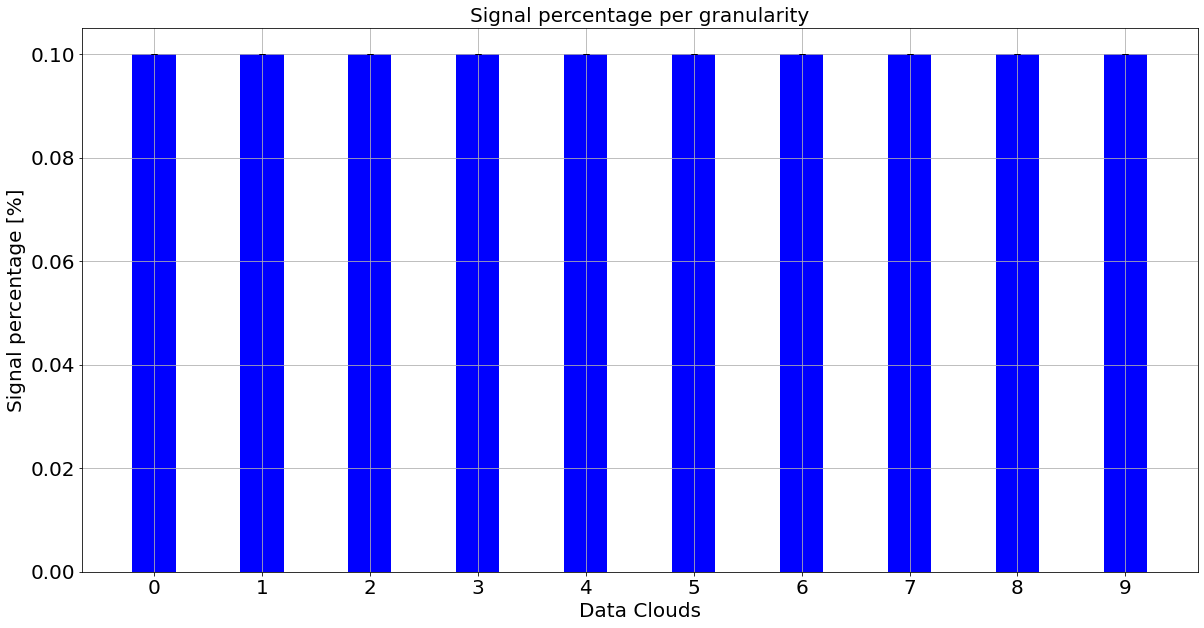

In [54]:
plt.figure(figsize=(20,10))
ax = plt.subplot()

x = range(len(percent_mean))

ax.bar(x,percent_mean, width=0.4, color='b', align='center')

plt.plot([x,x], [percent_mean[:] - percent_std[:], 
                     percent_mean[:] + percent_std[:]], 'k_-')

ax.set_xticks(x)
ax.set_title('Signal percentage per granularity', fontsize=20)
ax.set_ylabel('Signal percentage [%]', fontsize=20)
ax.set_xlabel('Data Clouds', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(df['Granularity'], df['N_Groups_Mean'], 'g.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20, color='g')
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.grid()

plt.savefig('results/True_Positive_Rate.png', bbox_inches='tight')
plt.show()

# Análise do Modelo

In [16]:
results_df = pd.DataFrame(columns = ['Granularity',
                                     'True_Positive_Rate_Mean', 'True_Positive_Rate_Std',
                                     'False_Positive_Rate_Mean', 'False_Positive_Rate_Std',
                                     'True_Positive_Mean', 'True_Positive_Std',
                                     'True_Negative_Mean', 'True_Negative_Std',
                                     'False_Positive_Mean', 'False_Positive_Std',
                                     'False_Negative_Mean', 'False_Negative_Std',
                                     'N_Groups_Mean', 'N_Groups_Std',
                                     'Execution_Time_Mean', 'Execution_Time_Std'])


list_gra = [i for i in range(1,31,2)]

iterations = 20

for i in list_gra:
    df = pd.DataFrame(columns = ['Granularity',
                                'True_Positive',
                                'True_Negative',
                                'False_Positive',
                                'False_Negative',
                                'N_Groups',
                                'Execution_Time'])
    
    for j in range(iterations):
        df_aux = pd.read_csv("results/detection_info_{}_{}.csv".format(i,j))
        
        
        df_aux["Execution_Time"] = df_aux["Time_Elapsed"]
        
        tp = df_aux['True_Positive']
        tn = df_aux['True_Negative']
        fp = df_aux['False_Positive']
        fn = df_aux['False_Negative']

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        df_aux["True_Positive_Rate"] = tpr*100
        df_aux["False_Positive_Rate"] = fpr*100
        
        df = pd.concat([df, df_aux])
    
    df = df.reset_index()
    df = df.drop('index',1)
    
    df["Time_s"] = df["Execution_Time"].apply(lambda x: datetime.strptime(x,"%H:%M:%S.%f").time())
    for k in range(df.shape[0]):
        df.loc[k,'Time_s'] = ((df.loc[k,'Time_s'].hour*60 + 
                               df.loc[k,'Time_s'].minute)*60 + 
                                   df.loc[k,'Time_s'].second) + df.loc[k,'Time_s'].microsecond/1000000
    
    
    
    results_dict = {'Granularity':i,
                    'True_Positive_Rate_Mean': df['True_Positive_Rate'].mean(),
                    'True_Positive_Rate_Std': df['True_Positive_Rate'].std(),
                    'False_Positive_Rate_Mean': df['False_Positive_Rate'].mean(),
                    'False_Positive_Rate_Std': df['False_Positive_Rate'].std(),
                    'True_Positive_Mean': df['True_Positive'].mean(), 
                    'True_Positive_Std': df['True_Positive'].std(),
                    'True_Negative_Mean': df['True_Negative'].mean(), 
                    'True_Negative_Std': df['True_Negative'].std(),
                    'False_Positive_Mean': df['False_Positive'].mean(), 
                    'False_Positive_Std': df['False_Positive'].std(),
                    'False_Negative_Mean': df['False_Negative'].mean(), 
                    'False_Negative_Std': df['False_Negative'].std(),
                    'N_Groups_Mean': df['N_Groups'].mean(), 
                    'N_Groups_Std': df['N_Groups'].std(),
                    'Execution_Time_Mean': df['Time_s'].mean(), 
                    'Execution_Time_Std': df['Time_s'].std()}
    
    results_df = results_df.append(results_dict, ignore_index=True)
    
df = results_df
df.to_csv('results/results_df.csv')

In [17]:
df

,Granularity,True_Positive_Rate_Mean,True_Positive_Rate_Std,False_Positive_Rate_Mean,False_Positive_Rate_Std,True_Positive_Mean,True_Positive_Std,True_Negative_Mean,True_Negative_Std,False_Positive_Mean,False_Positive_Std,False_Negative_Mean,False_Negative_Std,N_Groups_Mean,N_Groups_Std,Execution_Time_Mean,Execution_Time_Std
0,1.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,297.00,0.000000,0.00,0.000000,3.00,0.000000,1.55,0.510418,16.864528,1.021058
1,3.0,1.666667,7.453560,2.912458,2.421275,0.05,0.223607,288.35,7.191186,8.65,7.191186,2.95,0.223607,26.25,3.226127,17.793409,0.999025
2,5.0,10.000000,15.672078,15.858586,10.190928,0.30,0.470162,249.90,30.267057,47.10,30.267057,2.70,0.470162,96.05,7.883861,20.965995,1.351966
3,7.0,45.000000,32.936231,46.447811,13.149011,1.35,0.988087,159.05,39.052562,137.95,39.052562,1.65,0.988087,226.55,17.258026,24.080359,1.474586
4,9.0,60.000000,31.715106,70.252525,12.111499,1.80,0.951453,88.35,35.971151,208.65,35.971151,1.20,0.951453,393.10,17.182917,9.898571,0.712865
5,11.0,80.000000,27.359423,80.471380,9.374932,2.40,0.820783,58.00,27.843548,239.00,27.843548,0.60,0.820783,529.90,16.726594,10.943537,0.758575
6,13.0,91.666667,14.808722,89.629630,7.498354,2.75,0.444262,30.80,22.270112,266.20,22.270112,0.25,0.444262,637.65,12.545811,11.652333,0.551848
7,15.0,91.666667,14.808722,93.602694,6.387506,2.75,0.444262,19.00,18.970892,278.00,18.970892,0.25,0.444262,716.75,11.986286,12.184750,0.712103
8,17.0,96.666667,10.259784,96.245791,4.542697,2.90,0.307794,11.15,13.491810,285.85,13.491810,0.10,0.307794,766.25,9.535943,12.285464,0.680587
9,19.0,96.666667,10.259784,98.249158,3.174734,2.90,0.307794,5.20,9.428959,291.80,9.428959,0.10,0.307794,800.70,7.108927,12.349118,0.603053


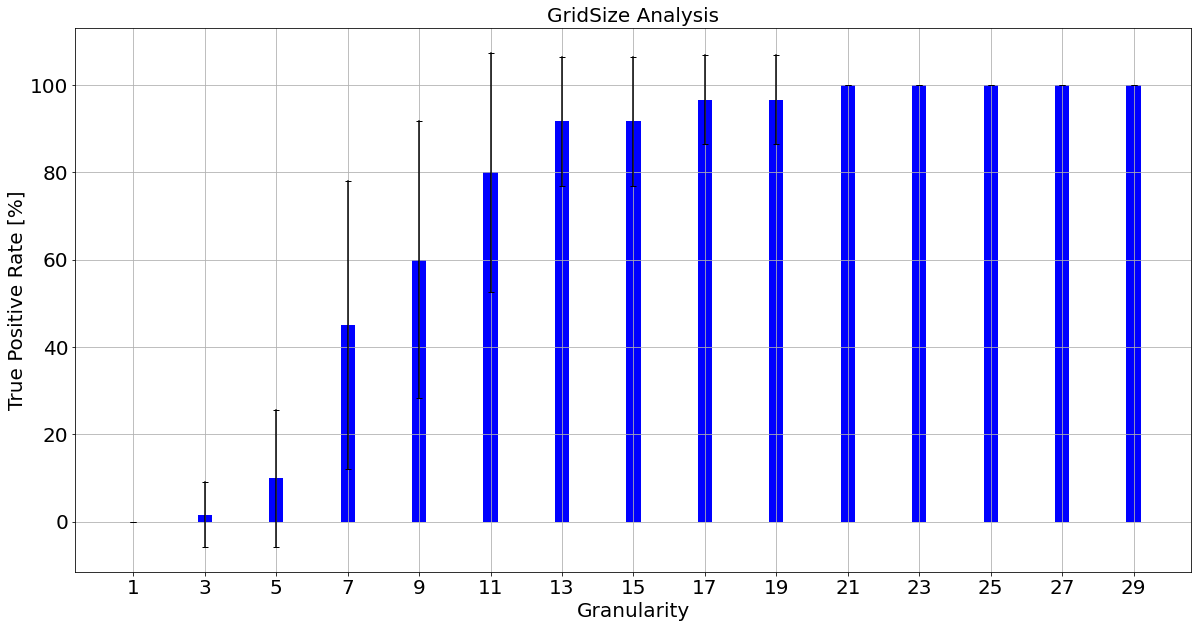

In [18]:
x = np.array(list_gra)

plt.figure(figsize=(20,10))
ax = plt.subplot()

ax.bar(x, df['True_Positive_Rate_Mean'], width=0.4, color='b', align='center')


plt.plot([x,x], [df['True_Positive_Rate_Mean'] - df['True_Positive_Rate_Std'], 
                     df['True_Positive_Rate_Mean'] + df['True_Positive_Rate_Std']], 'k_-')

ax.set_xticks(x)
ax.set_title('GridSize Analysis', fontsize=20)
ax.set_ylabel('True Positive Rate [%]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(df['Granularity'], df['N_Groups_Mean'], 'g.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20, color='g')
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.grid()

plt.savefig('results/True_Positive_Rate.png', bbox_inches='tight')
plt.show()

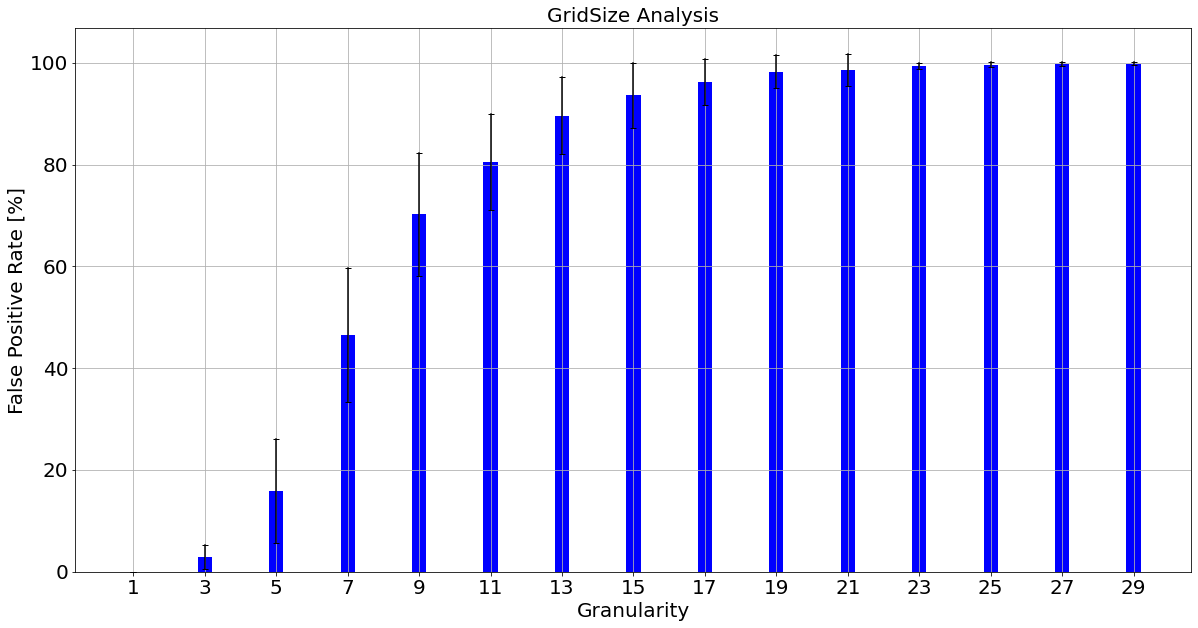

In [19]:
x = np.array(list_gra)

plt.figure(figsize=(20,10))
ax = plt.subplot()

ax.bar(x, df['False_Positive_Rate_Mean'], width=0.4, color='b', align='center')


plt.plot([x,x], [df['False_Positive_Rate_Mean'] - df['False_Positive_Rate_Std'], 
                     df['False_Positive_Rate_Mean'] + df['False_Positive_Rate_Std']], 'k_-')

ax.set_xticks(x)
ax.set_title('GridSize Analysis', fontsize=20)
ax.set_ylabel('False Positive Rate [%]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)


# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(df['Granularity'], df['N_Groups_Mean'], 'g.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20, color='g')
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.grid()

plt.savefig('results/False_Positive_Rate.png', bbox_inches='tight')
plt.show()

# Tempo de Execução

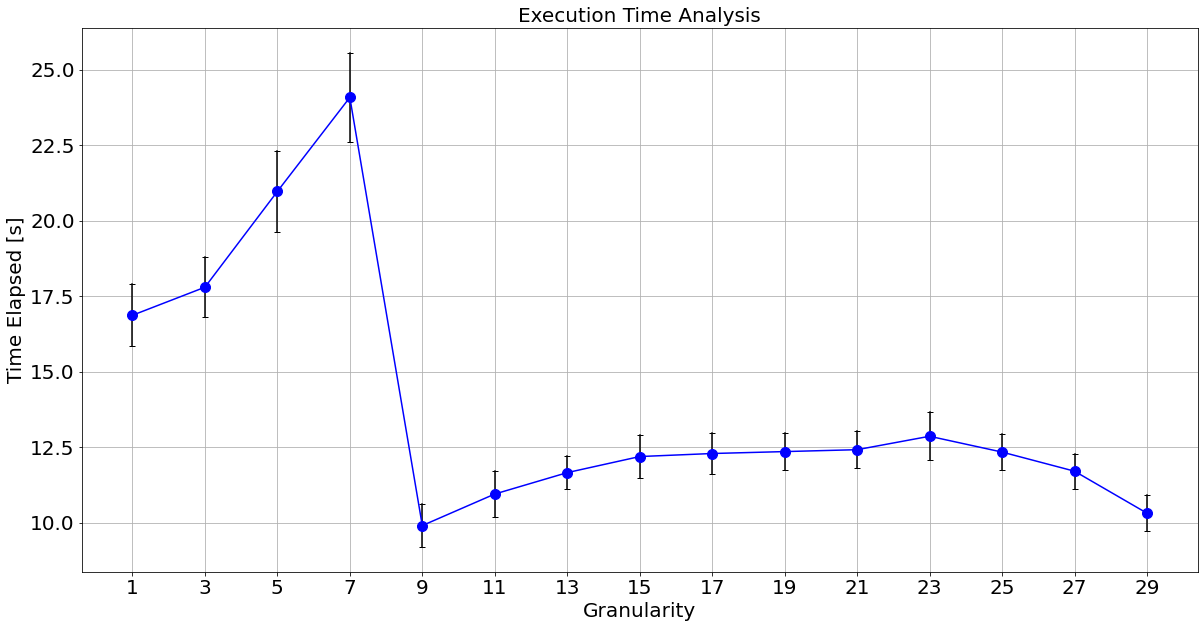

In [20]:
plt.figure(figsize=(20,10))
ax = plt.subplot()



ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Execution Time Analysis', fontsize=20)
ax.set_ylabel('Time Elapsed [s]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)

ax.set_xticks(x)

plt.plot([x,x], [df['Execution_Time_Mean'] - df['Execution_Time_Std'], 
                     df['Execution_Time_Mean'] + df['Execution_Time_Std']], 'k_-')

plt.plot(df['Granularity'], df['Execution_Time_Mean'], 'b.-', markersize=20)
plt.grid()

# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(df['Granularity'], df['N_Groups_Mean'], 'r.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20, color='r')
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('results/Execution_time_2.png', bbox_inches='tight')
plt.show()

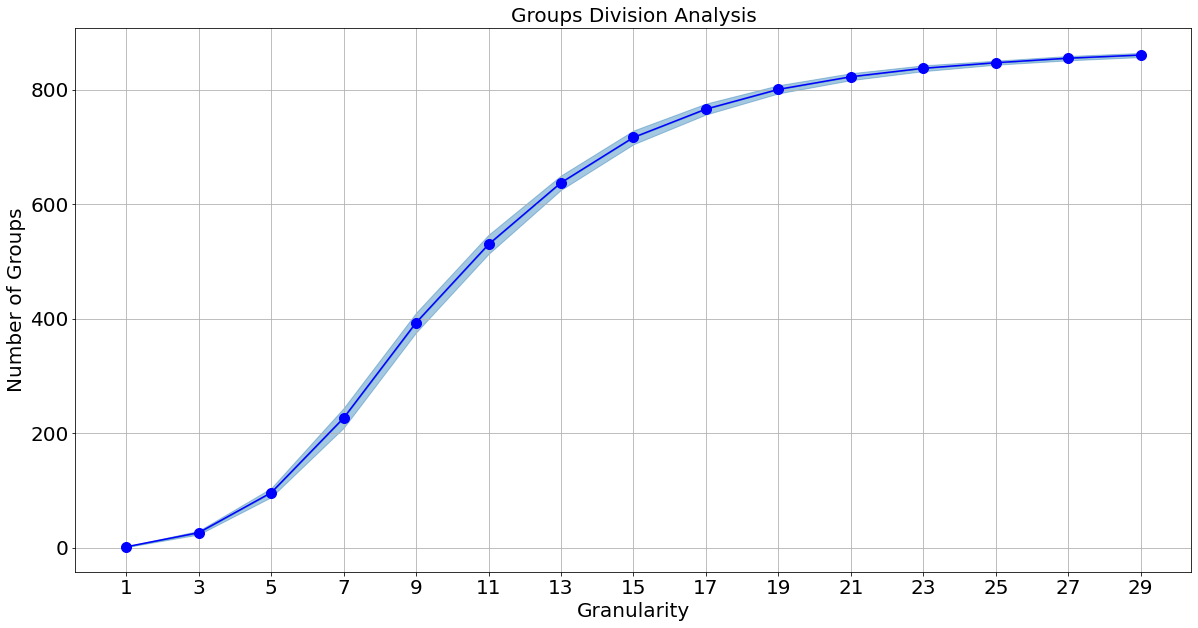

In [21]:
plt.figure(figsize=(20,10))
ax = plt.subplot()

plt.plot(df['Granularity'], df['N_Groups_Mean'], 'b.-', markersize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Groups Division Analysis', fontsize=20)
ax.set_ylabel('Number of Groups', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)

palette = sn.color_palette()[0]

# Plot da sombra entre a media e o maximo e minimo instantaneo
plt.fill_between(x,df['N_Groups_Mean'], df['N_Groups_Mean']+df['N_Groups_Std'], alpha=.4, color=palette)
plt.fill_between(x,df['N_Groups_Mean'], df['N_Groups_Mean']-df['N_Groups_Std'], alpha=.4, color=palette)

ax.set_xticks(x)

plt.grid()

plt.savefig('results/Number_of_Groups.png', bbox_inches='tight')
plt.show()

# ROC

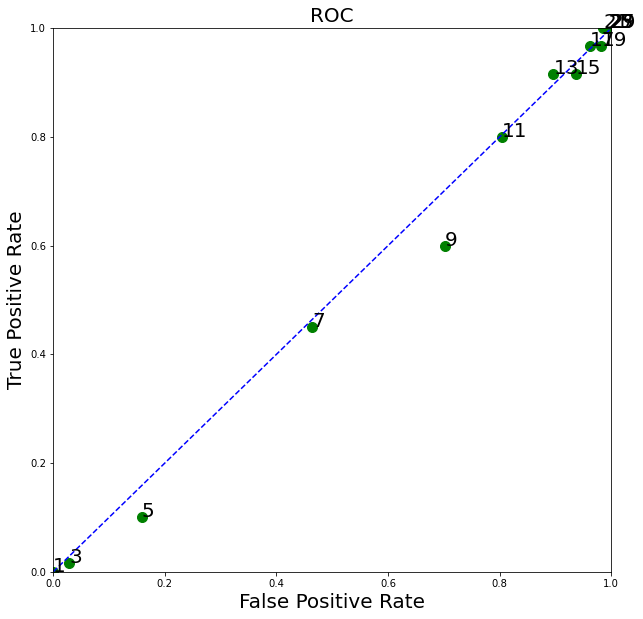

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df['False_Positive_Rate_Mean']/100, df['True_Positive_Rate_Mean']/100, c='g', s=100)
for i, txt in enumerate(x):
    ax.annotate(txt, (df['False_Positive_Rate_Mean'][i]/100, df['True_Positive_Rate_Mean'][i]/100), fontsize=20)    

ax.set_title('ROC', fontsize=20)
ax.plot([0, 1], [0, 1],'b--')    
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.savefig('results/ROC_2.png', bbox_inches='tight')

plt.show()

In [23]:
df[df['Granularity'] == 7]

,Granularity,True_Positive_Rate_Mean,True_Positive_Rate_Std,False_Positive_Rate_Mean,False_Positive_Rate_Std,True_Positive_Mean,True_Positive_Std,True_Negative_Mean,True_Negative_Std,False_Positive_Mean,False_Positive_Std,False_Negative_Mean,False_Negative_Std,N_Groups_Mean,N_Groups_Std,Execution_Time_Mean,Execution_Time_Std
3,7.0,45.0,32.936231,46.447811,13.149011,1.35,0.988087,159.05,39.052562,137.95,39.052562,1.65,0.988087,226.55,17.258026,24.080359,1.474586


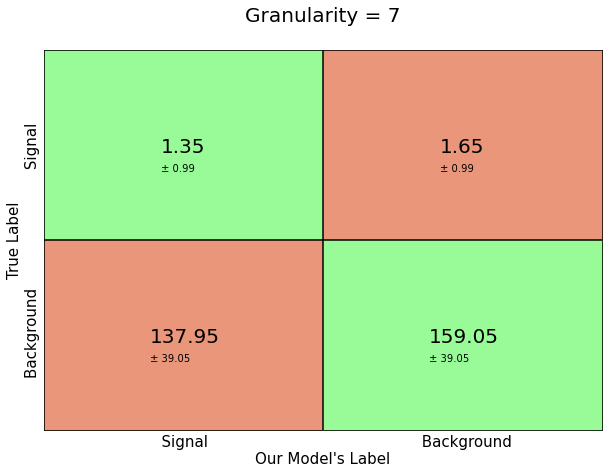

In [28]:
gra = 7


matrix = [ float(df[df['Granularity'] == gra]["True_Positive_Mean"]),  
           float(df[df['Granularity'] == gra]["False_Negative_Mean"]),
           float(df[df['Granularity'] == gra]["False_Positive_Mean"]), 
           float(df[df['Granularity'] == gra]["True_Negative_Mean"])]

matrix2 = [ float(df[df['Granularity'] == gra]["True_Positive_Std"]),  
           float(df[df['Granularity'] == gra]["False_Negative_Std"]),
           float(df[df['Granularity'] == gra]["False_Positive_Std"]), 
           float(df[df['Granularity'] == gra]["True_Negative_Std"])]


fig = plt.figure(figsize=[10,7])
        
y_label = ['Anomaly Event', 'Normal Event']
x_label = ['Anomaly Event', 'Normal Event']


plt.plot([0,2],[1,1], color='k')
plt.plot([1,1],[0,2], color='k')


plt.fill_between([0,1],[1,1],[2,2], color='palegreen')
plt.fill_between([1,2],[1,1],[2,2], color='darksalmon')
plt.fill_between([0,1],[0,0],[1,1], color='darksalmon')
plt.fill_between([1,2],[0,0],[1,1], color='palegreen')


for i in range(4):
    if i < 2:
        y = 1.46
    else:
        y = 0.46
        
    if i % 2 == 0:
        x = 0.5
    else:
        x = 1.5
    a = len(list(str(matrix[i])))
    x = x - a*0.02
    
    plt.annotate('{:.2f}'.format(matrix[i]), (x, y), fontsize=20)
    plt.annotate('\u00B1 {:.2f}'.format(matrix2[i]), (x, y-0.1), fontsize=10)

plt.title('Granularity = {}\n'.format(gra), fontsize=20)
plt.xticks([])
plt.yticks([])
plt.xlim([0,2])
plt.ylim([0,2])
plt.xlabel("      Signal                                             Background\nOur Model's Label", fontsize=15)
plt.ylabel("True Label\nBackground                         Signal    ", fontsize=15)
plt.grid(False)
plt.show()